In [46]:
import pandas as pd
import numpy as np
import random as rnd
import warnings
warnings.filterwarnings("ignore")

from sdv.tabular import GaussianCopula
from sdv.tabular import CTGAN
from sdv.tabular import CopulaGAN
from sdv.tabular import TVAE
from sdv.metrics.tabular import CSTest, KSTest

import random
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d

In [47]:
class Manhattan(object):
    """
    Manhattan distance to the mean template vector.
    """

    def fit(self, X):
        self.X = X
        self.mean = X.mean(axis=0)

    def decision_function(self, X):
        if X.ndim == 1:
            X = X[np.newaxis, :]
        return np.abs((X - self.mean)).sum(axis=1)


class ManhattanScaled(object):
    """
    Manhattan scaled distance to the mean template vector.
    """

    def fit(self, X):
        self.X = X
        self.mean = X.mean(axis=0)
        self.absdev = np.abs(X - self.mean).mean(axis=0)
        
    
    def decision_function(self, X):
        if X.ndim == 1:
            X = X[np.newaxis, :]
        return np.abs((X - self.mean) / self.absdev).sum(axis=1)

In [48]:
def calculate_eer(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)
    eer = brentq(lambda x: 1.0 - x - interp1d(fpr, tpr)(x), 0.0, 1.0)
    return eer

In [49]:
# all data
df = pd.read_csv("sapipin_no_outliers.csv")
users = set(df['user'])
# exclude userid = 93, this user forms a single cluster
# users.remove(93)

# read results of clustering
df_slow = pd.read_csv("sapipin_slow.csv")
users_slow = set(df_slow['user'])

df_medium = pd.read_csv("sapipin_medium.csv")
users_medium = set(df_medium['user'])

df_fast = pd.read_csv("sapipin_fast.csv")
users_fast = set(df_fast['user'])


# select 55 users for synthetic training
num_users_train = 55
random.seed(42)

users_train = []
while len(users_train) < 55:
    sample = rnd.sample(users, 1)
    if users_train.count(sample[0])==0:
        users_train.append(sample[0])
print(users_train)

users_train_slow = [x for x in users_slow if x in users_train]
users_train_medium = [x for x in users_medium if x in users_train]
users_train_fast = [x for x in users_fast if x in users_train]

print("Synthetic training")
print('SLOW', users_train_slow)
print('MEDIUM', users_train_medium)
print('FAST', users_train_fast)

users_auth_slow = [x for x in users_slow if x not in users_train]
users_auth_medium = [x for x in users_medium if x not in users_train]
users_auth_fast = [x for x in users_fast if x not in users_train]

print("Authentication")
print('SLOW', users_auth_slow)
print('MEDIUM', users_auth_medium)
print('FAST', users_auth_fast)

users_auth = [x for x in users if x not in users_train]

# exclude user id = 93
users_auth.remove(93)

df_train = df[ df['user'].isin(users_train)]
df_auth = df[ df['user'].isin(users_auth)]

df_auth_slow = df[ df['user'].isin(users_auth_slow)]
df_auth_medium = df[ df['user'].isin(users_auth_medium)]
df_auth_fast = df[ df['user'].isin(users_auth_fast)]



[82, 15, 4, 95, 36, 32, 29, 18, 14, 87, 70, 12, 76, 55, 5, 28, 30, 65, 78, 72, 26, 92, 84, 90, 54, 58, 105, 1, 99, 21, 44, 20, 49, 13, 46, 110, 45, 34, 6, 94, 59, 69, 16, 11, 71, 38, 108, 81, 80, 112, 47, 74, 25, 91, 9]
Synthetic training
SLOW [105.0, 84.0, 21.0, 25.0, 30.0]
MEDIUM [5.0, 11.0, 13.0, 20.0, 34.0, 38.0, 45.0, 47.0, 49.0, 58.0, 59.0, 70.0, 72.0, 74.0, 76.0, 78.0, 91.0]
FAST [1.0, 4.0, 6.0, 9.0, 12.0, 14.0, 15.0, 16.0, 18.0, 26.0, 28.0, 29.0, 32.0, 36.0, 44.0, 46.0, 54.0, 55.0, 65.0, 69.0, 71.0, 80.0, 81.0, 82.0, 87.0, 90.0, 92.0, 94.0, 95.0, 99.0, 108.0, 110.0, 112.0]
Authentication
SLOW [89.0, 33.0, 68.0, 73.0, 77.0, 88.0, 60.0, 61.0]
MEDIUM [2.0, 7.0, 10.0, 17.0, 22.0, 37.0, 39.0, 40.0, 50.0, 51.0, 52.0, 56.0, 57.0, 63.0, 66.0, 75.0, 79.0, 98.0, 100.0, 101.0]
FAST [3.0, 8.0, 19.0, 23.0, 24.0, 27.0, 31.0, 35.0, 41.0, 42.0, 43.0, 48.0, 53.0, 62.0, 64.0, 67.0, 83.0, 85.0, 86.0, 97.0, 102.0, 103.0, 104.0, 106.0, 107.0, 109.0, 111.0]


In [73]:
# model = GaussianCopula()
# model = CTGAN()
model = TVAE()
model.fit(df_train)
df_synth = model.sample()
# df_synth.describe()

In [74]:

df_list = [('ALL', df_auth), ('SLOW', df_auth_slow), ('MEDIUM', df_auth_medium), ('FAST', df_auth_fast)]


for (name, df_eval) in df_list:

    auc_list = list()

    userids = set(df_eval['user'].to_list())

    print("%s: #users %2d" % (name, len(userids)) )

    auc_mean_10 = []
    auc_std_10 = []
    for i in range (0,10):
        for userid in userids:
            user_train_data = df_eval.loc[df_eval.iloc[:, -1].isin([userid])]

            # Select data for training
            user_train_data = user_train_data.drop(user_train_data.columns[-1], axis=1)
            user_array = user_train_data.values

            train_samples = 10

            num_samples = user_array.shape[0]
            user_train = user_array[2:train_samples, :]
            user_test = user_array[train_samples:num_samples, :]

            # num, dim = user_test.shape
            # synth_user_data = df_synth.loc[df_synth.iloc[:, -1].isin([userid])]
            # synth_user_data = synth_user_data.drop(synth_user_data.columns[-1], axis=1)
            # synth_user_array = synth_user_data.values
            
            num, dim = user_test.shape
            synth_user_data = df_synth.sample(n = num)
            synth_user_data = synth_user_data.drop(synth_user_data.columns[-1], axis=1)
            synth_user_array = synth_user_data.values
            
            clf = ManhattanScaled()

            clf.fit(user_train)


            positive_scores = clf.decision_function(user_test)
            negative_scores = clf.decision_function(synth_user_array)

            # positive_scores, negative_scores = score_normalization(positive_scores, negative_scores)

            # 0 - inlier; 1 - outlier
            zeros = np.zeros(len(positive_scores))
            ones = np.ones(len(negative_scores))
            y = np.concatenate((zeros, ones), axis=0)
            y_pred = np.concatenate((positive_scores, negative_scores), axis=0)

            auc = roc_auc_score(y, y_pred)
            eer = calculate_eer(y, y_pred)
            auc_list.append(auc)
        # print("\tAUC mean %5.2f STD %5.2f" % (np.mean(auc_list), np.std(auc_list)))
        auc_mean_10.append( np.mean(auc_list) )
        auc_std_10.append(np.std(auc_list))
    print("\tAUC 10 mean %5.2f STD %5.2f" % (np.mean(auc_mean_10), np.mean(auc_std_10)))


ALL: #users 55
	AUC 10 mean  0.90 STD  0.11
SLOW: #users  8
	AUC 10 mean  0.94 STD  0.05
MEDIUM: #users 20
	AUC 10 mean  0.89 STD  0.12
FAST: #users 27
	AUC 10 mean  0.88 STD  0.10


In [52]:
def calculate_average_time_lengh(datalist):
    total_time = []
    for i in range( len(datalist) ):
        total_time.append(sum( datalist[i]))

    return np.mean(total_time)

In [65]:

df_list = [('ALL', df_auth)]
rows = []
for (name, df_eval) in df_list:

    auc_list = list()

    userids = set(df_eval['user'].to_list())

    print("%s: #users %2d" % (name, len(userids)) )

    
    for userid in userids:
        user_train_data = df_eval.loc[df_eval.iloc[:, -1].isin([userid])]

        # Select data for training
        user_train_data = user_train_data.drop(user_train_data.columns[-1], axis=1)
        user_array = user_train_data.values

        train_samples = 10

        num_samples = user_array.shape[0]
        user_train = user_array[2:train_samples, :]
        user_test = user_array[train_samples:num_samples, :]

        #Calculate  average typing time (samples 2:10)
        avg_time = calculate_average_time_lengh(user_train)

        auc_10 = []
        for i in range (0,10):        
            num, dim = user_test.shape
            synth_user_data = df_synth.sample(n = num)
            synth_user_data = synth_user_data.drop(synth_user_data.columns[-1], axis=1)
            synth_user_array = synth_user_data.values
            
            clf = ManhattanScaled()

            clf.fit(user_train)

            positive_scores = clf.decision_function(user_test)
            negative_scores = clf.decision_function(synth_user_array)

            # positive_scores, negative_scores = score_normalization(positive_scores, negative_scores)

            # 0 - inlier; 1 - outlier
            zeros = np.zeros(len(positive_scores))
            ones = np.ones(len(negative_scores))
            y = np.concatenate((zeros, ones), axis=0)
            y_pred = np.concatenate((positive_scores, negative_scores), axis=0)

            auc = roc_auc_score(y, y_pred)
            eer = calculate_eer(y, y_pred)
        auc_10.append(auc)
        # print("\t%4d, %5.2f, %5.2f" % (userid, avg_time, np.mean(auc_10)))
        rows.append([userid, avg_time, np.mean(auc_10)])
      
    df_totaltime_auc = pd.DataFrame(rows, columns = ['userid', 'Total time', 'AUC'])
    # print(df_totaltime_auc)



ALL: #users 55


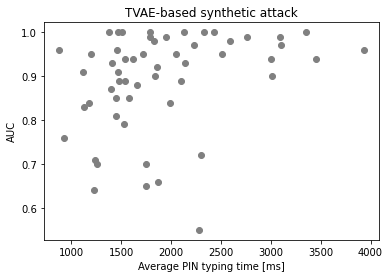

In [66]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.scatter(df_totaltime_auc['Total time'],df_totaltime_auc['AUC'], color='gray', marker = 'o')  
plt.ylabel('AUC')
plt.xlabel('Average PIN typing time [ms]')
plt.title('TVAE-based synthetic attack')
plt.show()